In [1]:
import numpy as np
import numpy.ma as ma # for masked arrays

%matplotlib inline
import matplotlib.pyplot as plt

from netCDF4 import Dataset

In [195]:

#########################

ncfile = 'Atlantic_for_turb.nc'
#ncfile = 'GS_for_turb.nc'

#########################

nc = Dataset(ncfile,'r')
us = nc.variables['us'][0,:,:].T
vs = nc.variables['vs'][0,:,:].T

pm = nc.variables['pm'][0,:,:].T
pn = nc.variables['pn'][0,:,:].T
f = nc.variables['f'][0,:,:].T

lon = nc.variables['lon'][0,:,:].T
lat = nc.variables['lat'][0,:,:].T
nc.close()

x = np.cumsum(1./pm,0)*1e-3
y = np.cumsum(1./pn,1)*1e-3


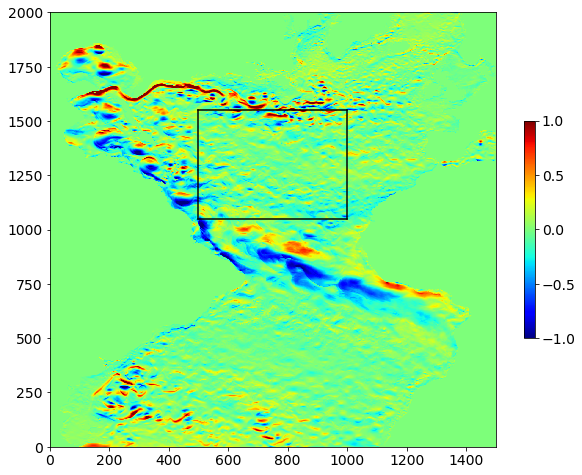

In [196]:

if 'Atlantic' in ncfile: # for the Atlantic domain
    zoom = [500,1000,1050,1550]
elif 'GS' in ncfile:
    #full domain
    #zoom = [100,1500,100,1500]
    #region with submesoscale
    zoom = [400,800,0,400]
else:
    zoom = [350,1000,200,850]
    
############################

fig=plt.figure(figsize=(10.,8.))

ax1 = fig.add_subplot(111,facecolor='Gainsboro')     
CS1 = ax1.pcolormesh(ma.masked_invalid(us.T), cmap=plt.get_cmap('jet'),vmin=-1.,vmax=1.,rasterized=True)

plt.plot([zoom[0],zoom[1]],[zoom[2],zoom[2]],'-k')
plt.plot([zoom[0],zoom[1]],[zoom[3],zoom[3]],'-k')
plt.plot([zoom[0],zoom[0]],[zoom[2],zoom[3]],'-k')
plt.plot([zoom[1],zoom[1]],[zoom[2],zoom[3]],'-k')


plt.colorbar(CS1,shrink=0.5);
ax1.axis('tight'); 



Text(0, 0.5, 'lat')

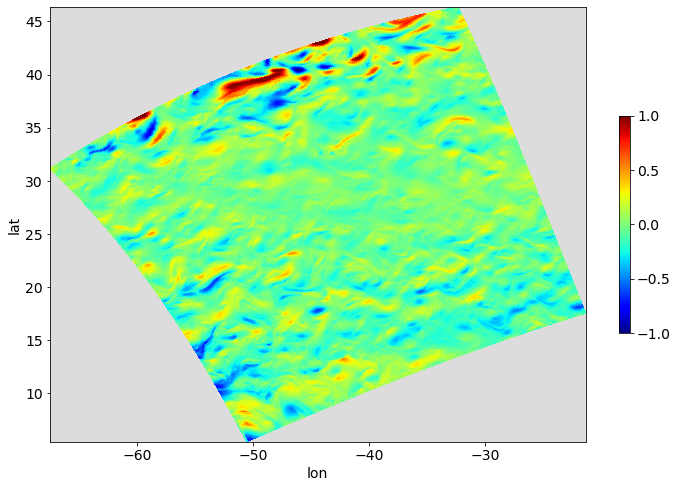

In [197]:
fig=plt.figure(figsize=(12.,8.))

ax1 = fig.add_subplot(111,facecolor='Gainsboro')     

CS1 = ax1.pcolormesh(lon[zoom[0]:zoom[1],zoom[2]:zoom[3]],lat[zoom[0]:zoom[1],zoom[2]:zoom[3]],ma.masked_invalid(us[zoom[0]:zoom[1],zoom[2]:zoom[3]]), cmap=plt.get_cmap('jet'),vmin=-1.,vmax=1.,rasterized=True)
plt.colorbar(CS1,shrink=0.5);
ax1.axis('tight'); ax1.set_xlabel('lon'); ax1.set_ylabel('lat')



Text(0, 0.5, 'km')

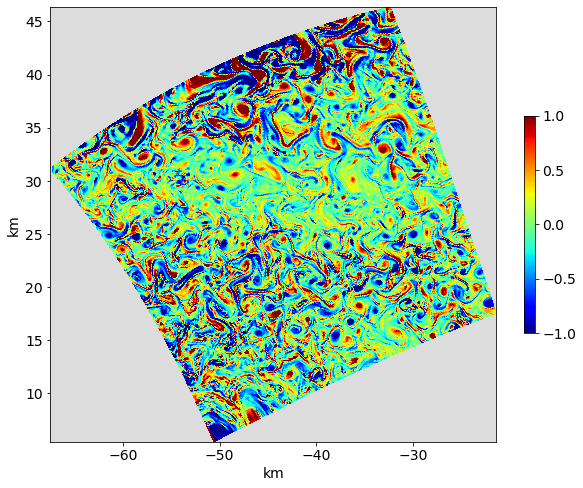

In [198]:
vrt = (np.diff(vs,axis=0)*pm.mean() - np.diff(us,axis=1)*pn.mean())/f.mean()

fig=plt.figure(figsize=(10.,8.))

ax1 = fig.add_subplot(111,facecolor='Gainsboro')     
CS1 = ax1.pcolormesh(lon[zoom[0]:zoom[1],zoom[2]:zoom[3]],lat[zoom[0]:zoom[1],zoom[2]:zoom[3]],ma.masked_invalid(vrt[zoom[0]:zoom[1],zoom[2]:zoom[3]]), cmap=plt.get_cmap('jet'),vmin=-1.,vmax=1.,rasterized=True)
plt.colorbar(CS1,shrink=0.5);
ax1.axis('tight'); ax1.set_xlabel('km'); ax1.set_ylabel('km')

In [199]:
#from scipy import fft
from scipy import fftpack

def fft_1d(myvar, axis=0):
    # if var is 'u', it should be axis=0
    nx = myvar.shape[(axis+1)%2]
    fftemp = np.zeros((nx//2))
    han = np.hanning(nx)
    #han = np.ones(nx)
    for iy in range(myvar.shape[axis]):
        if axis==1: fft0 = fftpack.fft(myvar[:,iy]*han)
        elif axis==0: fft0 = fftpack.fft(myvar[iy,:]*han)
        fftemp = fftemp + (fft0*np.conj(fft0))[:nx//2]
    fftemp = fftemp/myvar.shape[axis]
    return fftemp


#######################################################

def u2rho(var_u):

    [M,Lp]=var_u.shape
    Mp=M+1
    Mm=M-1
    var_rho=np.zeros((Mp,Lp))
    var_rho[1:M,:]=0.5*(var_u[0:Mm,:]+var_u[1:M,:])
    var_rho[0,:]=var_rho[1,:]
    var_rho[Mp-1,:]=var_rho[M-1,:]

    return var_rho
#######################################################

def v2rho(var_v):

    [Mp,L]=var_v.shape
    Lp=L+1
    Lm=L-1
    var_rho=np.zeros((Mp,Lp))
    var_rho[:,1:L]=0.5*(var_v[:,0:Lm]+var_v[:,1:L])
    var_rho[:,0]=var_rho[:,1]
    var_rho[:,Lp-1]=var_rho[:,L-1]
    return var_rho

###################################################################################

fontsize1 = 14
fontsize2 = 20
fontsize3 = format(22)
font = {'size'   : fontsize1}
plt.rc('font', **font)



In [200]:
u = u2rho(us)[zoom[0]:zoom[1],zoom[2]:zoom[3]]
v = v2rho(vs)[zoom[0]:zoom[1],zoom[2]:zoom[3]]

#################

nx1 = u.shape[0]; res = np.mean(1/pm[zoom[0]:zoom[1],zoom[2]:zoom[3]])

k = np.arange(nx1//2)/(res*nx1)*1000./(2*np.pi)# in cpkm
k2 = fftpack.fftfreq(nx1,res)[:nx1//2]
dk = (k[2] - k[1])

fft_uy = fft_1d(u-np.mean(u),axis=0) / dk
fft_ux = fft_1d(u-np.mean(u),axis=1) / dk

fft_uy += fft_1d(v-np.mean(v),axis=1) / dk
fft_ux += fft_1d(v-np.mean(v),axis=0) / dk


<ipython-input-201-b6a257148d30>:9: RuntimeWarning: divide by zero encountered in power
  plot2, = plt.loglog(k, (k/k[10])**(-3)*fft_uy[10],'-',color='g',linewidth=2);
<ipython-input-201-b6a257148d30>:9: RuntimeWarning: invalid value encountered in multiply
  plot2, = plt.loglog(k, (k/k[10])**(-3)*fft_uy[10],'-',color='g',linewidth=2);
<ipython-input-201-b6a257148d30>:10: RuntimeWarning: divide by zero encountered in power
  plot3, = plt.loglog(k, (k/k[1])**(-2)*fft_uy[1],'--',color='k',linewidth=1);
<ipython-input-201-b6a257148d30>:10: RuntimeWarning: invalid value encountered in multiply
  plot3, = plt.loglog(k, (k/k[1])**(-2)*fft_uy[1],'--',color='k',linewidth=1);
<ipython-input-201-b6a257148d30>:11: RuntimeWarning: divide by zero encountered in power
  plot4, = plt.loglog(k, (k/k[1])**(-5./3.)*fft_uy[1],'-',color='k',linewidth=1);
<ipython-input-201-b6a257148d30>:11: RuntimeWarning: invalid value encountered in multiply
  plot4, = plt.loglog(k, (k/k[1])**(-5./3.)*fft_uy[1],'-',colo

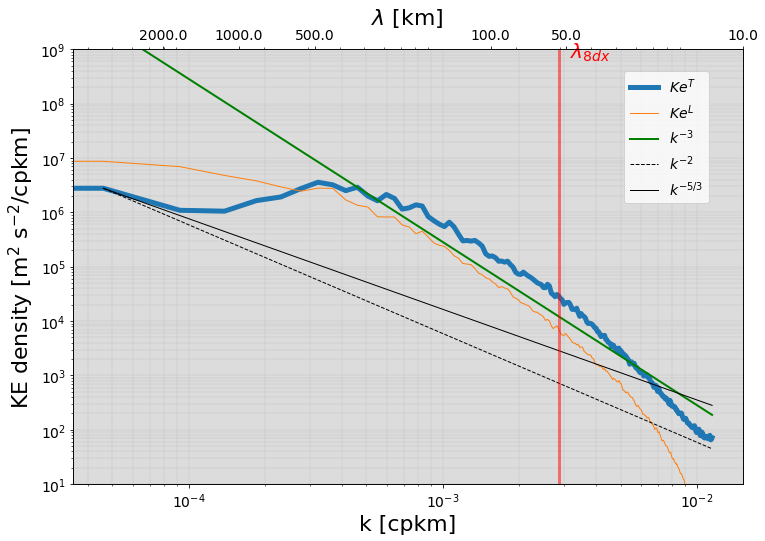

In [201]:
def plot(fft_uy,fft_ux,name1,name2):

    fig=plt.figure(figsize=(12.,8))

    ax = fig.add_subplot(111,facecolor='Gainsboro')   
    plot1, = plt.loglog(k, fft_uy,'-',linewidth=5);
    plot1b, = plt.loglog(k, fft_ux,'-',linewidth=1);

    plot2, = plt.loglog(k, (k/k[10])**(-3)*fft_uy[10],'-',color='g',linewidth=2);
    plot3, = plt.loglog(k, (k/k[1])**(-2)*fft_uy[1],'--',color='k',linewidth=1);
    plot4, = plt.loglog(k, (k/k[1])**(-5./3.)*fft_uy[1],'-',color='k',linewidth=1);

    # Legend
    plt.legend([plot1,plot1b,plot2,plot3,plot4], [name1,name2,r'$k^{-3}$',
                                r'$k^{-2}$',                        
                                r'$k^{-5/3}$'],
                                bbox_to_anchor=(0.95, 0.95),loc=0, borderaxespad=0.)
    plt.grid(b=True, which='both', color='0.65',linestyle='-',linewidth=0.2)
    ax.set_ylim([10, 1e9])
    # Labels
    ax.set_xlabel('k [cpkm]',fontsize=fontsize3); 
    ax.set_ylabel('KE density [m$^2$ s$^{-2}$/cpkm]',fontsize=fontsize3); 

    # Plot a second x axis (to show wavelength)
    axy = ax.twiny()
    axy.set_xscale('log')
    axy.set_xlim(ax.get_xlim())
    axy.set_xlabel('$\lambda$ [km]',fontsize=fontsize3)
    #lp = np.array([0.5,1.,5.,10,50,100,500])
    lp = np.array([10.,50.,100.,500.,1000.,2000.])  
    kp = 1./lp
    axy.set_xticks(kp/(2*np.pi))
    axy.set_xticklabels([format(x) for x in lp])

    # Add Effective res. wavenumber
    lim=k[-1]/8*2
    ax.plot((lim,lim),ax.get_ylim(),'-r',linewidth=3.,alpha=0.5)
    ax.text(lim*1.1,ax.get_ylim()[-1]*0.7,r'$\lambda_{8dx}$',color='r',fontsize=fontsize2)
    
    
    
plot(fft_uy,fft_ux,r'$Ke^{T}$',r'$Ke^{L}$')


In [202]:
###################################################################################

def azimuthalAverage(image, center=None, stddev=False, returnradii=False, return_nr=False,
        binsize=1., weights=None, steps=False, interpnan=False, left=None, right=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is
             None, which then uses the center of the image (including
             fractional pixels).
    stddev - if specified, return the azimuthal standard deviation instead of the average
    returnradii - if specified, return (radii_array,radial_profile)
    return_nr   - if specified, return number of pixels per radius *and* radius
    binsize - size of the averaging bin.  Can lead to strange results if
        non-binsize factors are used to specify the center and the binsize is
        too large
    weights - can do a weighted average instead of a simple average if this keyword parameter
        is set.  weights.shape must = image.shape.  weighted stddev is undefined, so don't
        set weights and stddev.
    steps - if specified, will return a double-length bin array and radial
        profile so you can plot a step-form radial profile (which more accurately
        represents what's going on)
    interpnan - Interpolate over NAN values, i.e. bins where there is no data?
        left,right - passed to interpnan; they set the extrapolated values

    If a bin contains NO DATA, it will have a NAN value because of the
    divide-by-sum-of-weights component.  I think this is a useful way to denote
    lack of data, but users let me know if an alternative is prefered...
   
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)
    if center is None:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
    r = np.hypot(x - center[0], y - center[1])
    if weights is None:
        weights = np.ones(image.shape)
    elif stddev:
        raise ValueError("Weighted standard deviation is not defined.")
    # the 'bins' as initially defined are lower/upper bounds for each bin
    # so that values will be in [lower,upper)  
    nbins = np.int(np.round(r.max() / binsize)+1)
    maxbin = nbins * binsize
    bins = np.linspace(0,maxbin,nbins+1)
    # but we're probably more interested in the bin centers than their left or right sides...
    bin_centers = (bins[1:]+bins[:-1])/2.0
    # Find out which radial bin each point in the map belongs to
    whichbin = np.digitize(r.flat,bins)
    # how many per bin (i.e., histogram)?
    # there are never any in bin 0, because the lowest index returned by digitize is 1
    nr = np.bincount(whichbin)[1:]
    # recall that bins are from 1 to nbins (which is expressed in array terms by arange(nbins)+1 or xrange(1,nbins+1) )
    # radial_prof.shape = bin_centers.shape
    if stddev:
        radial_prof = np.array([image.flat[whichbin==b].std() for b in range(1,nbins+1)])
    else:
        # add renormalization (2pi/k/n)
        #norm = np.array([weights.flat[whichbin==b].sum() for b in xrange(1,np.int(nbins)+1)])  
        #norm_k = np.array([2*np.pi*(b) for b in xrange(1,np.int(nbins)+1)])       
        radial_prof = np.array([(image*weights).flat[whichbin==b].sum() / weights.flat[whichbin==b].sum() * 2*np.pi*b for b in range(1,np.int(nbins)+1)])  
        #or not
        #radial_prof = np.array([(image*weights).flat[whichbin==b].sum() for b in xrange(1,np.int(nbins)+1)])        
    #import pdb; pdb.set_trace()
    if interpnan:
        radial_prof = np.interp(bin_centers,bin_centers[radial_prof==radial_prof],radial_prof[radial_prof==radial_prof],left=left,right=right)
    if steps:
        xarr = np.array(zip(bins[:-1],bins[1:])).ravel()
        yarr = np.array(zip(radial_prof,radial_prof)).ravel()
        return xarr,yarr
    elif returnradii:
        return bin_centers,radial_prof
    elif return_nr:
        return nr,bin_centers,radial_prof
    else:
        return radial_prof


########################


def fft_2d(myvar):
    han = np.sqrt(np.outer(np.hanning(myvar.shape[0]),np.hanning(myvar.shape[1])))
    F1 = fftpack.fft2(myvar*han)  
    psd2D = fftpack.fftshift(np.abs(F1*np.conj(F1)))/(myvar.shape[0]*myvar.shape[1])
    fftemp = azimuthalAverage(psd2D)[:myvar.shape[0]//2]
    return fftemp



<ipython-input-202-4f47541f2d42>:61: RuntimeWarning: invalid value encountered in double_scalars
  radial_prof = np.array([(image*weights).flat[whichbin==b].sum() / weights.flat[whichbin==b].sum() * 2*np.pi*b for b in range(1,np.int(nbins)+1)])
<ipython-input-201-b6a257148d30>:9: RuntimeWarning: divide by zero encountered in power
  plot2, = plt.loglog(k, (k/k[10])**(-3)*fft_uy[10],'-',color='g',linewidth=2);
<ipython-input-201-b6a257148d30>:10: RuntimeWarning: divide by zero encountered in power
  plot3, = plt.loglog(k, (k/k[1])**(-2)*fft_uy[1],'--',color='k',linewidth=1);
<ipython-input-201-b6a257148d30>:11: RuntimeWarning: divide by zero encountered in power
  plot4, = plt.loglog(k, (k/k[1])**(-5./3.)*fft_uy[1],'-',color='k',linewidth=1);


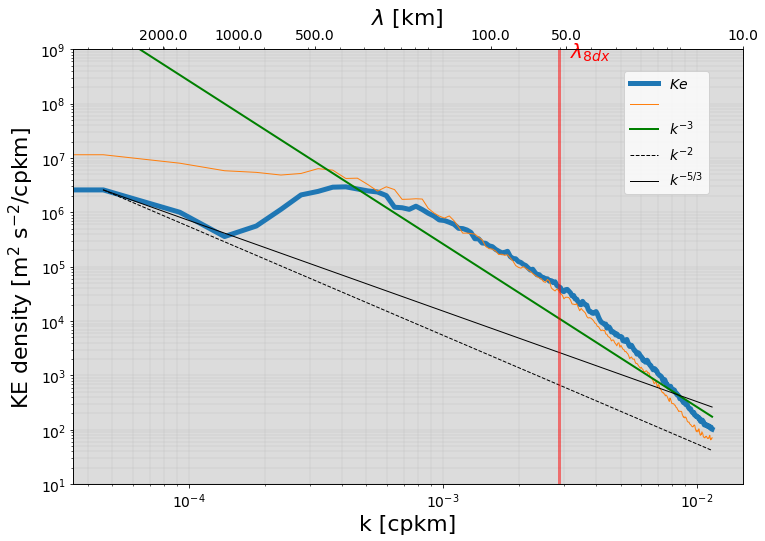

In [203]:
fft_u = fft_2d(u-np.mean(u)) / dk
fft_v = fft_2d(v-np.mean(v)) / dk

plot(fft_u+fft_v,fft_uy+fft_ux,r'$Ke$',' ')


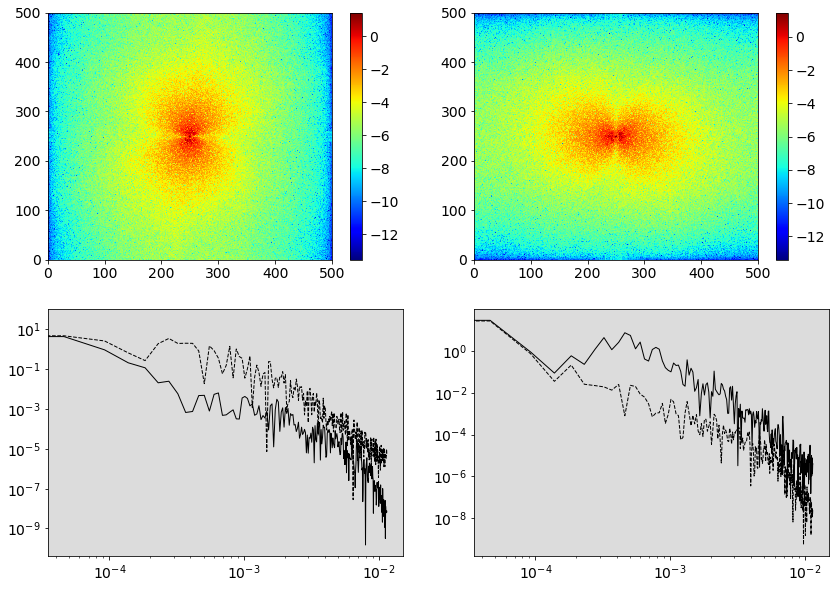

In [204]:
fig=plt.figure(figsize=(14.,10))
ax = fig.add_subplot(221,facecolor='Gainsboro')   
    
han = np.sqrt(np.outer(np.hanning(u.shape[0]),np.hanning(u.shape[1])))
F1 = fftpack.fft2(u*han)
psdu = fftpack.fftshift(np.abs(F1*np.conj(F1)))/(u.shape[0]*u.shape[1])
plt.pcolormesh(np.log10(psdu).T, cmap=plt.get_cmap('jet')); plt.colorbar()

#####

ax = fig.add_subplot(222,facecolor='Gainsboro')   
    
han = np.sqrt(np.outer(np.hanning(u.shape[0]),np.hanning(u.shape[1])))
F1 = fftpack.fft2(v*han)
psdv = fftpack.fftshift(np.abs(F1*np.conj(F1)))/(u.shape[0]*u.shape[1])
plt.pcolormesh(np.log10(psdv).T, cmap=plt.get_cmap('jet')); plt.colorbar()
#plt.pcolormesh(fftpack.fft2(u))

#####

ax = fig.add_subplot(223,facecolor='Gainsboro')   
    
plt.loglog(k, psdu[u.shape[0]//2:,u.shape[1]//2],'-',color='k',linewidth=1);
plt.loglog(k, psdu[u.shape[0]//2,u.shape[1]//2:],'--',color='k',linewidth=1);

#####

ax = fig.add_subplot(224,facecolor='Gainsboro')   
    
plt.loglog(k, psdv[v.shape[0]//2:,v.shape[1]//2],'-',color='k',linewidth=1);
plt.loglog(k, psdv[v.shape[0]//2,v.shape[1]//2:],'--',color='k',linewidth=1);

